# we choose to forecast min temperature with Prophet because Prophet is known for its good performance in modelling seasonal data

In [ ]:
!pip install fbprophet

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import numpy as np
import os
from datetime import datetime
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
import holidays
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False


In [ ]:
df = pd.read_csv('/content/monthly_min_temperature.csv').dropna()

In [ ]:
df['time']=pd.to_datetime(df['time'],dayfirst=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 0 to 145
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               146 non-null    datetime64[ns]
 1   MIN_TEMPERATURE_C  146 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.4 KB


In [ ]:
df.head()

,time,MIN_TEMPERATURE_C
0,2009-01-31,10
1,2009-02-28,8
2,2009-03-31,10
3,2009-04-30,11
4,2009-05-31,17


In [ ]:
ny_df_daily=df.set_index('time')

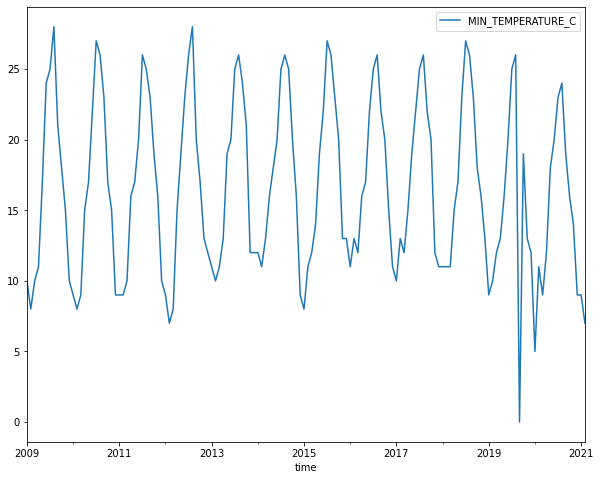

In [ ]:
ny_df_daily.plot()

In [ ]:
from fbprophet import Prophet

In [ ]:
ny_df_daily

,MIN_TEMPERATURE_C
time,
2009-01-31,10
2009-02-28,8
2009-03-31,10
2009-04-30,11
2009-05-31,17
...,...
2020-10-31,16
2020-11-30,14
2020-12-31,9


In [ ]:
ny_df_final=ny_df_daily.reset_index()[['time','MIN_TEMPERATURE_C']].rename({'time':'ds',
        'MIN_TEMPERATURE_C':'y'}, axis='columns')

In [ ]:
ny_df_final

,ds,y
0,2009-01-31,10
1,2009-02-28,8
2,2009-03-31,10
3,2009-04-30,11
4,2009-05-31,17
...,...,...
141,2020-10-31,16
142,2020-11-30,14
143,2020-12-31,9
144,2021-01-31,9


In [ ]:
train=ny_df_final[ny_df_final['ds'] <= '2018-12-31']
test=ny_df_final[(ny_df_final['ds'] > '2018-12-31')]

In [ ]:
train.shape

(120, 2)

In [ ]:
test.shape

(26, 2)

In [ ]:
test

,ds,y
120,2019-01-31,9
121,2019-02-28,10
122,2019-03-31,12
123,2019-04-30,13
124,2019-05-31,16
125,2019-06-30,20
126,2019-07-31,25
127,2019-08-31,26
128,2019-09-30,0
129,2019-10-31,19


# cross validation

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1,0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
    #'holidays_prior_scale' : [0.01, 0.1, 1.0, 10.0]
    #'changepoint_range' : [0.8,0.85,0.9,0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial = 730,horizon='365 days', parallel="processes")
    #by default,initial_training_
    #data_size=3*horizon_size and cutoff is every half horizon
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])


best_params = all_params[np.argmin(mapes)]
print(best_params)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2009-07-03 12:00:00 and 2017-12-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff386f3ad50>
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


In [ ]:

m = Prophet(interval_width=0.95,yearly_seasonality=True,
            changepoint_prior_scale=0.1,seasonality_prior_scale=0.1)
#,changepoint_range=1,)


In [ ]:
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
m.params

{'beta': array([[-0.20413429, -0.20865818,  0.05571163, -0.0358737 ,  0.0015842 ,
         -0.03064118, -0.01657206,  0.0088411 , -0.0173433 , -0.060476  ,
          0.07933642,  0.02056785, -0.0347124 ,  0.05239885, -0.01049032,
         -0.02759184, -0.00568481,  0.03015183,  0.01316282,  0.03752105]]),
 'delta': array([[ 1.71022115e-09, -8.91530612e-11, -1.37321462e-08,
         -6.17599787e-09,  4.77286934e-09,  3.75538589e-09,
         -1.75365252e-09, -1.34241325e-09, -2.09062218e-08,
         -2.41877048e-09, -1.85687099e-08, -4.22689973e-09,
         -3.81159744e-08, -1.24180637e-05, -4.05861155e-04,
         -1.43081831e-02, -7.70045913e-03, -1.04510553e-02,
         -3.07628570e-04, -3.63185450e-03, -2.01159740e-03,
         -6.13956469e-04, -3.91781883e-06, -1.63224714e-06,
         -1.21843805e-06]]),
 'k': array([[0.06808883]]),
 'm': array([[0.5759397]]),
 'sigma_obs': array([[0.04543425]]),
 'trend': array([[0.5759397 , 0.57646621, 0.57704913, 0.57761324, 0.57819616,
   

In [ ]:
future=pd.DataFrame({'ds' : []})
future.ds=test.ds

In [ ]:
future

,ds
120,2019-01-31
121,2019-02-28
122,2019-03-31
123,2019-04-30
124,2019-05-31
125,2019-06-30
126,2019-07-31
127,2019-08-31
128,2019-09-30
129,2019-10-31


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-01-31,10.604016,8.069987,13.230502
1,2019-02-28,10.733576,8.379019,13.271255
2,2019-03-31,11.552557,9.031741,14.127845
3,2019-04-30,15.285131,12.763544,17.815022
4,2019-05-31,18.451216,16.028448,20.891440


In [ ]:

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
21,2020-10-31,19.677382,17.080002,22.185576
22,2020-11-30,14.785908,12.264516,17.225938
23,2020-12-31,11.711367,9.164339,14.296220
24,2021-01-31,10.959509,8.541491,13.470168
25,2021-02-28,10.934396,8.614136,13.346950


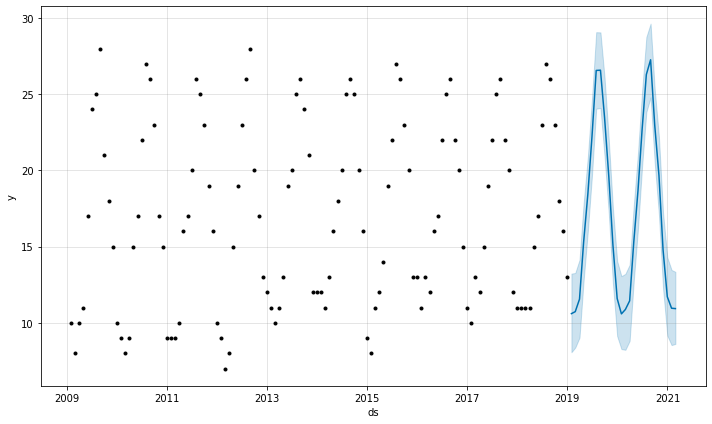

In [ ]:
fig=m.plot(forecast)


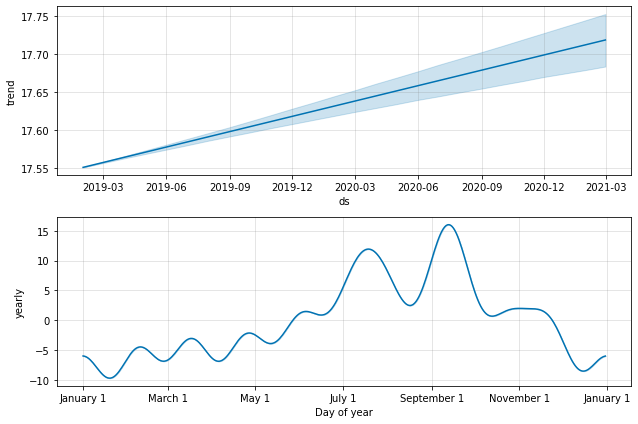

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
  #def mean_absolute_percentage_error(y_true, y_pred):
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    #return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  def smape(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 2/y_true.shape[0]*np.sum(np.abs(y_true-y_pred))/np.sum((np.abs(y_true)+np.abs(y_pred)))*100
  def mase(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    naive_pred=y_true[1:]
    return 1/y_true.shape[0]*np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true[:len(y_true)-1]-naive_pred))*(y_true.shape[0]-1)
  #def owe(y_true,y_pred):
   # return (mase(y_true,y_pred)+smape(y_true,y_pred))/2

  print('Evaluation metric results:-')
  print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
  print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
  print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
  #print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
  print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
  print('SMAPE is : '+str(smape(y_true,y_pred))+'\n')
  print('MASE is : '+str(mase(y_true,y_pred)))
  return

In [ ]:
from sklearn import metrics
import numpy as np

timeseries_evaluation_metrics_func(test['y'], forecast['yhat'])

Evaluation metric results:-
MSE is : 27.370495368165514
MAE is : 2.9554040749690125
RMSE is : 5.2316818871339565
R2 is : 0.32554023005577637

SMAPE is : 0.7235742016000642

MASE is : 0.636940533398494


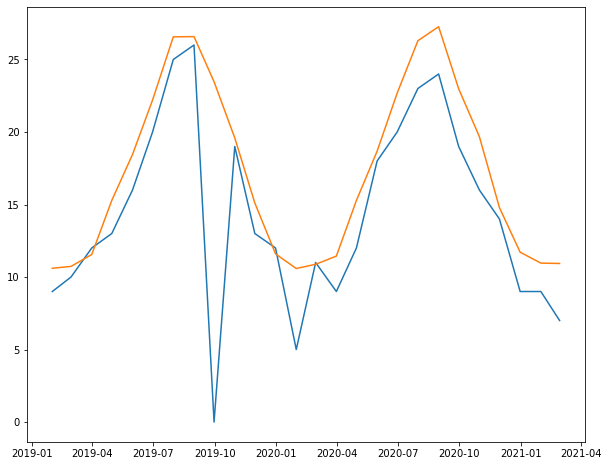

In [ ]:
time=df.time[-len(test.y):]
plt.plot(time,test['y'])
plt.plot(time,forecast.yhat)

In [ ]:
train=ny_df_final

In [ ]:
m = Prophet(interval_width=0.95,yearly_seasonality=True,
            changepoint_prior_scale=0.1,seasonality_prior_scale=0.1)
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future=pd.DataFrame({'ds' : []})
future.ds=pd.date_range(start='03/01/2021', end='03/01/2024', freq='M')

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2021-03-31,8.745998,4.748021,12.471763
1,2021-04-30,12.202948,8.220558,16.547781
2,2021-05-31,15.653801,11.642939,19.809784
3,2021-06-30,19.297358,15.287258,23.402119
4,2021-07-31,23.154193,19.051821,27.109110


In [ ]:

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
31,2023-10-31,15.236175,10.947929,19.355959
32,2023-11-30,10.631705,6.423946,14.939181
33,2023-12-31,7.363303,3.214834,11.390783
34,2024-01-31,5.626715,1.719747,9.973878
35,2024-02-29,6.241679,2.315247,10.077343


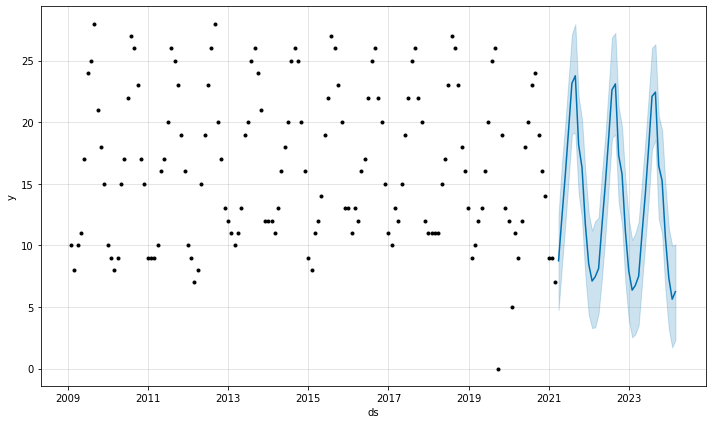

In [ ]:
fig=m.plot(forecast)


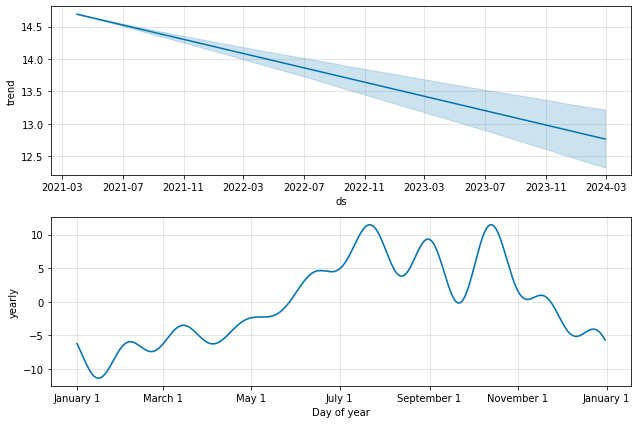

In [ ]:
fig2 = m.plot_components(forecast)

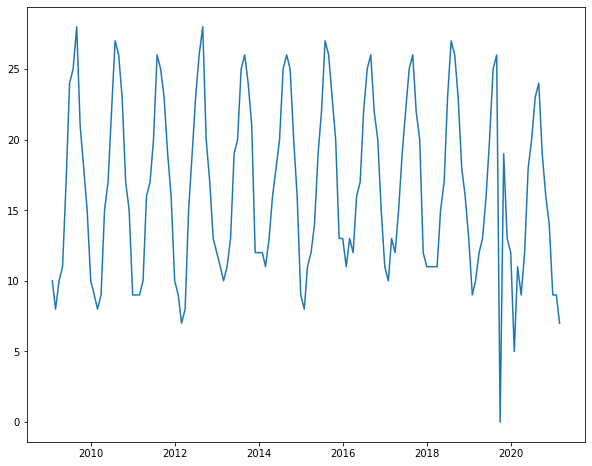

In [ ]:
plt.plot(train['ds'],train['y'])

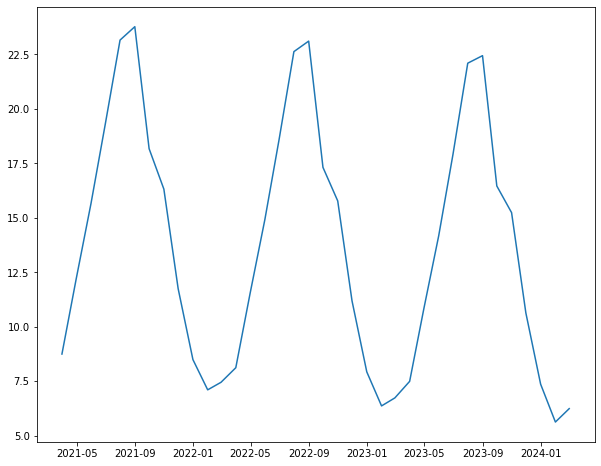

In [ ]:
# forecast min temperature until 2024
plt.plot(future['ds'],forecast['yhat'])

In [ ]:
forecast.yhat.to_csv('frcst_monthly_min_temp.csv')

# forecasting number of clients with linear regression

In [ ]:
df=pd.read_csv('/content/supervised_nbr_clients.csv')
X_train,y_train=np.array(df['nbr_clients_t_36'][:-12]).reshape(-1,1),np.array(df['nbr_clients_t'][:-12]).reshape(-1,1)
X_test,y_test=np.array(df['nbr_clients_t_36'][-12:]).reshape(-1,1),np.array(df['nbr_clients_t'][-12:]).reshape(-1,1)

In [ ]:
df.head()

,time,nbr_clients_t_36,nbr_clients_t
0,31/01/2018,3980,4869
1,28/02/2018,4023,4901
2,31/03/2018,4060,4943
3,30/04/2018,4094,4964
4,31/05/2018,4112,5020


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV


In [ ]:
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
model = Ridge()
param_search = { 
    'alpha': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'solver': ['auto','svd','cholesky','lsqr','sparse_cg','sag','saga']

}
tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2')#we 
#can define another metric as mentioned in the tuto
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [ ]:
best_model

Ridge(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='saga', tol=0.001)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


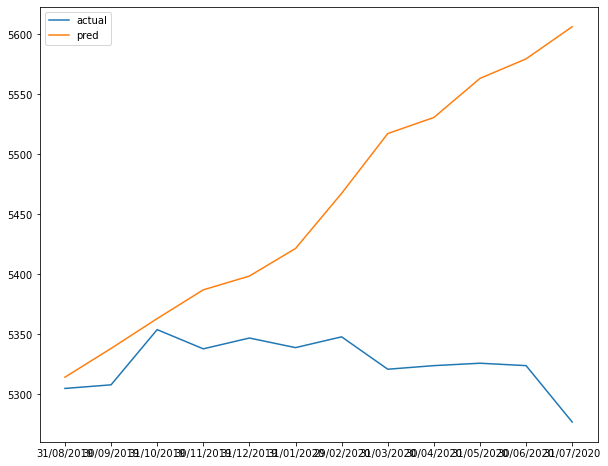

In [ ]:
y_pred=reg.predict(X_test.reshape(-1,1))
plt.plot(df.time[-12:],y_test,label="actual")
plt.plot(df.time[-12:],y_pred,label="pred")
plt.legend()
plt.show()

# forecast 

In [ ]:
X_frcst=np.array(df['nbr_clients_t']).reshape((-1,1))
y_frcst=reg.predict(X_frcst)#since 01/2021 to 07/2023

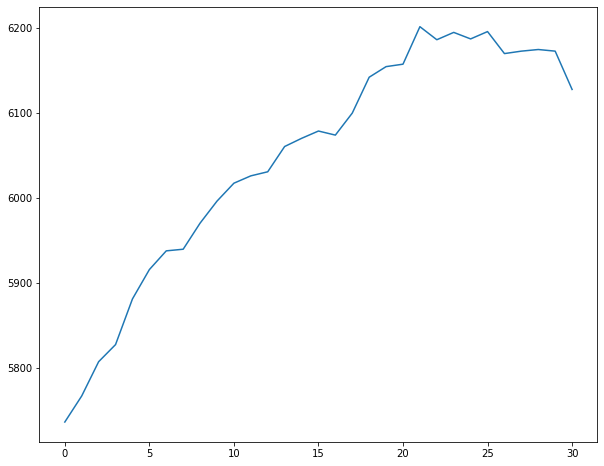

In [ ]:
plt.plot(y_frcst)

In [ ]:
pd.DataFrame(y_frcst,columns=['frcst_clients']).to_csv('frcst_clients.csv')